# Correlation plots

start by importing the necessary packages and defining some varibles:
- `JSON_DIR`: the directory containing the output json files from `pcmr rogi --cv` runs

In [72]:
from pathlib import Path

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from pandas.io.formats.style import Styler
import scipy.stats
import seaborn as sns

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

def rogi_rmse_corr(df):
    rogi = df["ROGI"].values
    errors = df["RMSE"].values
    r, _ = scipy.stats.pearsonr(rogi, errors)
    
    return r or 0

JSON_DIR = Path("../results/raw/cv/tdc+guac_v1")
VERSION = "v1"
FILTER_RAND = True

In [73]:
dfs = [pd.read_json(p) for p in JSON_DIR.iterdir()]
df = pd.concat(dfs, ignore_index=True)\
    .rename(
        columns={
            "dataset_and_task": "dataset",
            "rogi": "ROGI",
            "rmse": "RMSE",
            # "features": "representation"
        }
    )\
    .replace("morgan", "fp")\
    .sort_values(["model", "dataset", "features"])
df = df.rename(columns=dict(features="representation"))

if FILTER_RAND:
    df = df[~df.representation.str.contains('_rand')]
s_corr = df.groupby(["dataset", "model"]).apply(rogi_rmse_corr).fillna(0).rename("r")

df

/home/degraff/.conda/envs/pcmr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,representation,dataset,ROGI,n_valid,thresholds,sds_cg,model,r2,RMSE,mae,cg_sds,n_clusters
170,chemberta,ARIPIPRAZOLE_SIMILARITY,0.210304,10000,"[0.0, 0.017209783700000002, 0.0278593409, 0.03...","[0.264599811, 0.2645973218, 0.2645847591, 0.26...",KNN,0.401582,0.071241,0.056611,NaN,NaN
440,chemgpt,ARIPIPRAZOLE_SIMILARITY,0.215322,10000,"[0.0, 0.0142147075, 0.0382459532, 0.0488907343...","[0.264599811, 0.26459931130000003, 0.264599280...",KNN,0.244761,0.080037,0.063786,NaN,NaN
710,descriptor,ARIPIPRAZOLE_SIMILARITY,0.168301,10000,"[0.0, 0.0, 0.0106091976, 0.0206102781, 0.03062...","[0.264599811, 0.2645992061, 0.2645073187, 0.26...",KNN,0.697986,0.050605,0.039555,NaN,NaN
260,fp,ARIPIPRAZOLE_SIMILARITY,0.033185,10000,"[0.0, 0.0, 0.09302325580000001, 0.1290322581, ...",NaN,KNN,0.580140,0.059670,0.046421,"[0.264599811, 0.264599811, 0.2645997929, 0.264...","[10000, 9996, 9995, 9994, 9992, 9991, 9988, 99..."
620,gin,ARIPIPRAZOLE_SIMILARITY,0.203405,10000,"[0.0, 0.0026411219, 0.0153331475, 0.0308957665...","[0.264599811, 0.264599811, 0.264599811, 0.2645...",KNN,0.486784,0.065941,0.052146,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
438,chemgpt,ZALEPLON_MPO,0.349013,10000,"[0.0, 0.0142147075, 0.0382459532, 0.0488907343...","[0.4101976003, 0.4101976003, 0.4101974909, 0.4...",SVR,0.148863,0.092826,0.077552,NaN,NaN
708,descriptor,ZALEPLON_MPO,0.292480,10000,"[0.0, 0.0, 0.0106091976, 0.0206102781, 0.03062...","[0.4101976003, 0.4101968446, 0.409969970900000...",SVR,0.485503,0.072135,0.055450,NaN,NaN
258,fp,ZALEPLON_MPO,0.078294,10000,"[0.0, 0.0, 0.09302325580000001, 0.1290322581, ...",NaN,SVR,0.116135,0.094581,0.080203,"[0.4101976003, 0.4101976003, 0.4101884484, 0.4...","[10000, 9996, 9995, 9994, 9992, 9991, 9988, 99..."
618,gin,ZALEPLON_MPO,0.333256,10000,"[0.0, 0.0026411232, 0.015333145800000001, 0.03...","[0.4101976003, 0.4101976003, 0.4101975983, 0.4...",SVR,0.244760,0.087415,0.069838,NaN,NaN


## Marginalized corrleation distributions

In [74]:
DATASETS = s_corr.index.unique(0).tolist()
MODELS = s_corr.index.unique(1).tolist()

DATASET_COLORS = sns.color_palette(palette='pastel', n_colors=len(DATASETS))
MODEL_COLORS = sns.color_palette(palette='deep', n_colors=len(MODELS))
MARKERS = ['o', 'X', 'P', 's', 'D']

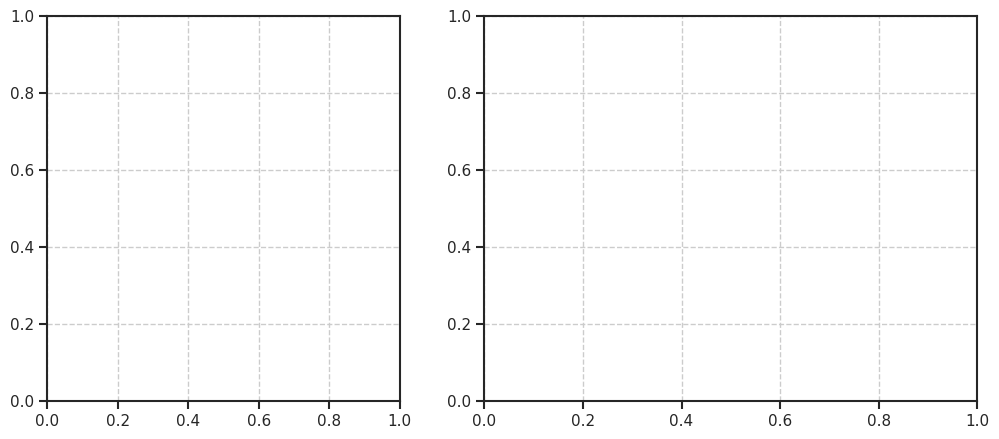

In [75]:
fig, label2ax = plt.subplot_mosaic([['models', 'datasets']], width_ratios=[5, 7], figsize=(12, 5))

In [76]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax = label2ax['models']

# Y = s_corr.values.reshape(len(DATASETS), len(MODELS), -1).mean(-1)
Y = s_corr.values.reshape(len(DATASETS), len(MODELS))
JITTER = 0.1

bp = ax.boxplot(
    Y,
    vert=True,
    labels=MODELS,
    widths=0.5,
    showmeans=True,
    patch_artist=True,
    boxprops=dict(lw=1.5, fc="None"),
    medianprops=dict(c=None),
    capprops=dict(lw=1.5),
    showfliers=False,
)

for median, c in zip(bp['medians'], MODEL_COLORS):
    median.set_color(c)

for j in range(Y.shape[1]):
    y = Y[:, j]
    x = (j + 1) + np.random.uniform(-JITTER, JITTER, y.shape)

    ax.plot(x, y, MARKERS[j], c=MODEL_COLORS[j], mew=1.5, ms=7.5)
    # ax.scatter(x, y, 50, DATASET_COLORS, MARKERS[j], edgecolor='k', linewidth=1.5)

ax.grid(True, axis='y', ls='--')
ax.set_xlabel("Model")
ax.set_ylabel(r"$r$")

fig.tight_layout()

In [77]:
# fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax = label2ax['datasets']
ax = sns.scatterplot(
    s_corr.reset_index(), y='dataset', x="r", hue='dataset', palette=DATASET_COLORS, 
    style="model", markers=MARKERS, style_order=MODELS,
    edgecolor="k", linewidth=1., s=33,
    legend=False, ax=ax
)

ax.set_xlim(-1.05, 1.05)
ax.grid(True, axis='x', ls='--')
ax.set_ylabel("Dataset")
ax.set_xlabel(r"$r$")
ax.tick_params(axis='y', labelsize=8)

legend_elements = [
    Line2D([0], [0], marker=marker, ls='', color='k', mfc='None', mew=1.5, label=model)
    for marker, model in zip(MARKERS, MODELS)
]

ax.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 1.0), facecolor="w", fontsize=8, ncols=len(MODELS)
)

fig.tight_layout()

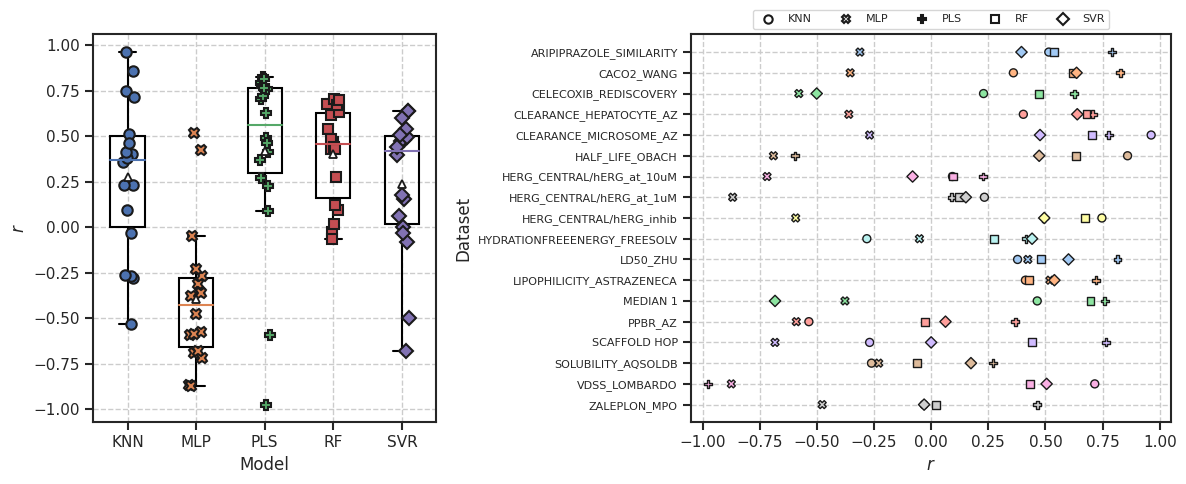

In [78]:
fig

In [60]:
fig.savefig(f"../results/figures/correlation/model-dataset_no-rand_{VERSION}.pdf", bbox_inches="tight")

## Correlation plots

### Single correlation plot



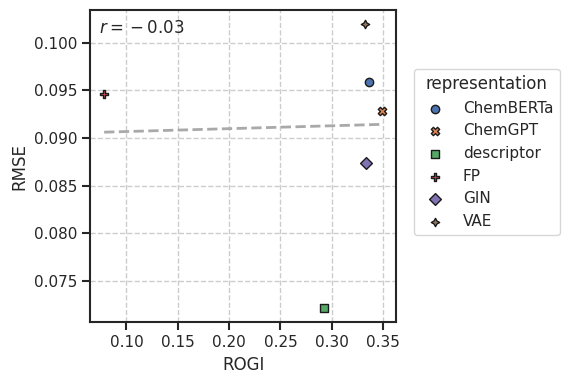

In [79]:
MODEL = "SVR"
DATASET = "ZALEPLON_MPO"

df_temp = df.query(f"model == '{MODEL}' & dataset == '{DATASET}'")
reprs, xs, ys = df_temp.representation.values, df_temp.ROGI.values, df_temp.RMSE.values

MARKERS = ['o', 'X', 's', 'P', 'D', (4, 1, 0), "^", (4, 1, 45)]
REP_LABELS = dict(fp="FP", vae="VAE", gin="GIN", chemberta="ChemBERTa", chemgpt="ChemGPT")

fig, ax = plt.subplots(figsize=(4.25, 4), layout='constrained')

for r, x, y, m in zip(reprs, xs, ys, MARKERS):
    ax.scatter(x, y, marker=m, edgecolor="k", linewidth=1, label=REP_LABELS.get(r, r))

res = scipy.stats.linregress(xs, ys)

x = np.array(xs)
y = res.slope * x + res.intercept
ax.plot([x.min(), x.max()], [y.min(), y.max()], '--', color="darkgrey")

ax.text(0.03, 0.97, rf"$r={res.rvalue:0.2f}$", ha="left", va="top", transform=ax.transAxes)
ax.tick_params(direction="out", left=True, bottom=True)
ax.set_xlabel("ROGI")
ax.set_ylabel("RMSE")

fig.legend(title="representation", loc="center left", bbox_to_anchor=(0.975, 0.6))
fig.tight_layout()

In [80]:
fig.savefig(f"../results/figures/correlation/zaleplon-svr_no-rand_{VERSION}.pdf", bbox_inches="tight")

### ALL plots

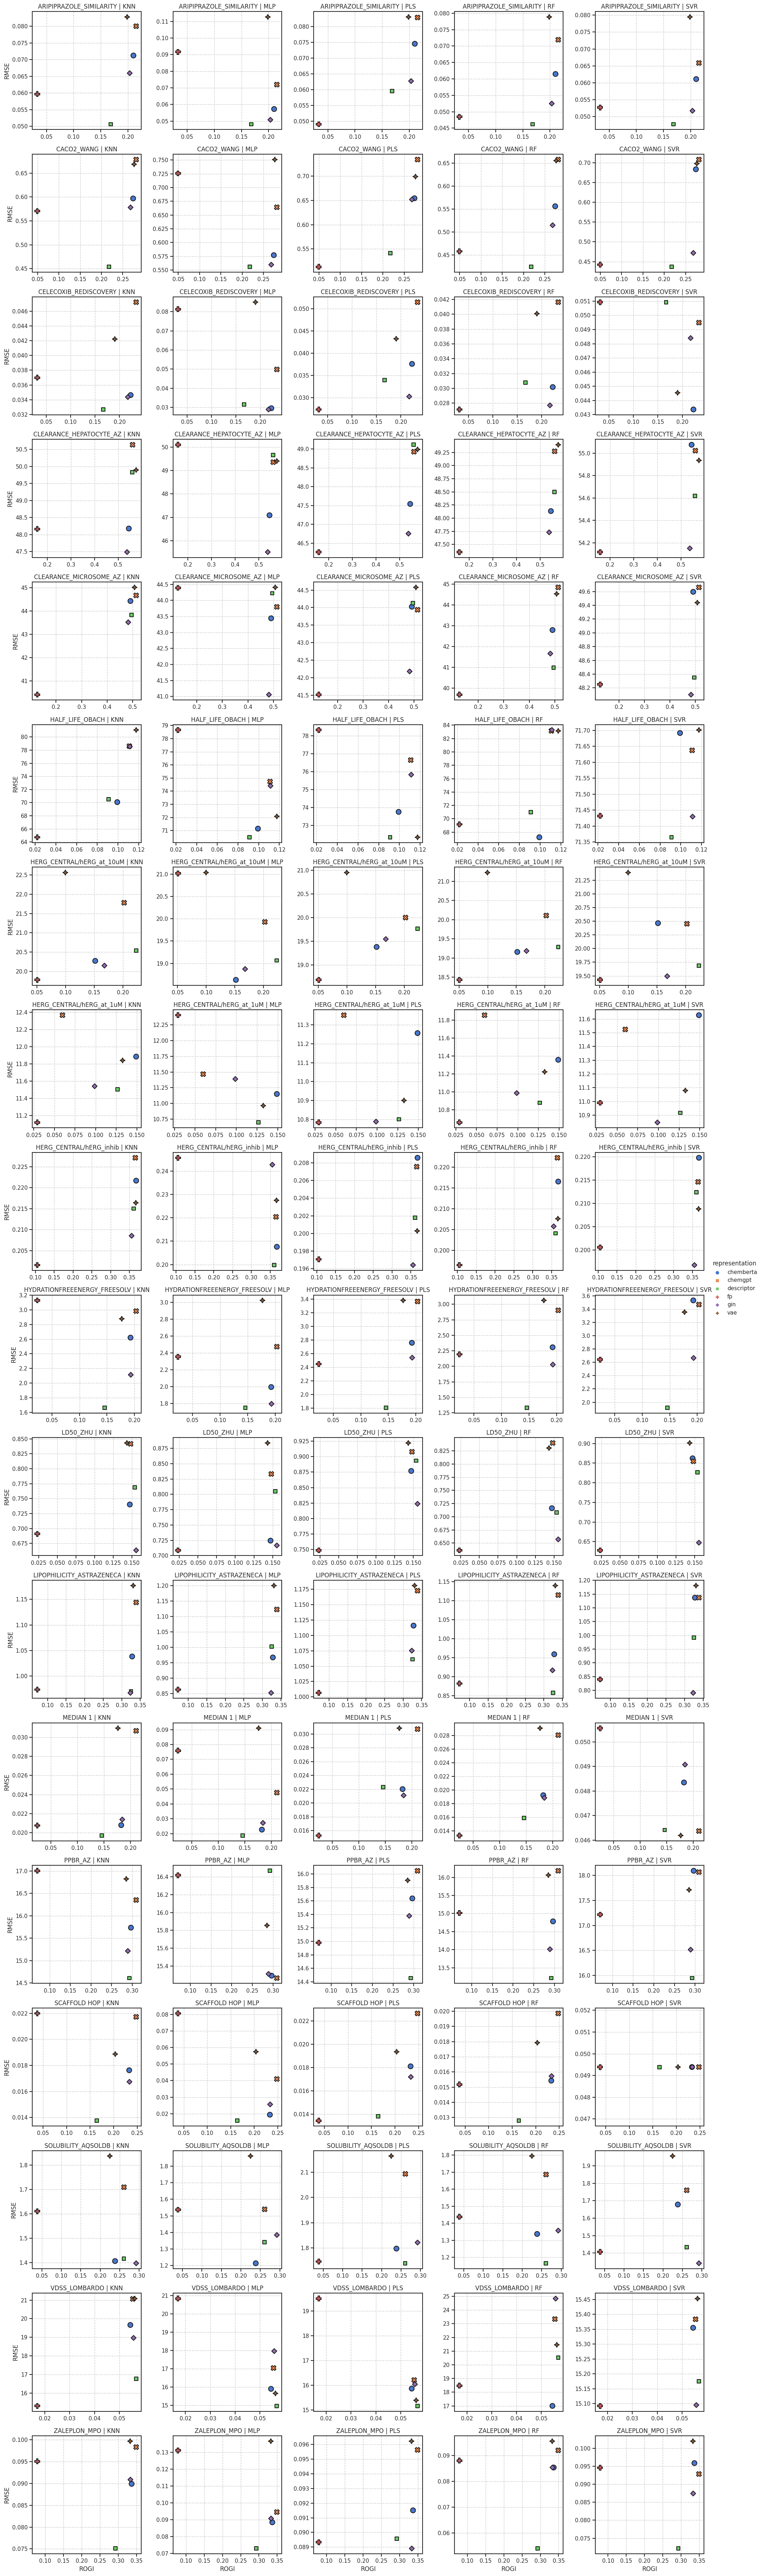

In [81]:
facetprops = dict(despine=False, sharex=False, sharey=False)

g = sns.relplot(
    df,
    x="ROGI", y="RMSE", col="model", row="dataset",
    hue="representation", style="representation", palette="muted",
    height=4, legend="auto", facet_kws=facetprops,
    edgecolor='k', linewidth=1.5, s=100
)

for i, ax in enumerate(g.axes.flat):
    ax.grid(True, ls="--")

g.set_titles(row_template="{row_name}", col_template="{col_name}")

In [82]:
g.savefig(f"../results/figures/correlation/all_no-rand_{VERSION}.pdf", bbox_inches="tight")

In [ ]:
def corr_plot(ax: plt.Axes, xs, ys, colors):
    BUFFER = 0.03

    for x, y, c in zip(xs, ys, colors):
        ax.scatter(x, y, 50, marker='o', color=c)

    r, _ = scipy.stats.pearsonr(xs, ys)
    s = rf"$r = {r:0.3f}$"
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='none')
    ax.text(
        0 + BUFFER, 1 - BUFFER, s,
        ha="left", va="top", fontsize=10, transform=ax.transAxes, bbox=bbox
    )
    
    # ax.yaxis.set_tick_params(which="both", direction="in", pad=6)
    ax.grid(True)

---
## GRAVEYARD
---

In [ ]:
TABLE_FILE.parent.mkdir(exist_ok=True, parents=True)

Styler(
    df.groupby(["dataset_and_task", 'range', "model"])\
        .mean()\
        .rename_axis(index={"dataset_and_task": "dataset"})\
        .rename(index=lambda s: s.lower().capitalize(), level=0),
    precision=3
)\
.format_index(escape="latex", axis=0, precision=3)\
.format_index(escape="latex", axis=1)\
.hide(axis=0, level=-1)\
.hide(["rogi", "r2", "rmse", "mae"], axis=1)\
.to_latex(TABLE_FILE, hrules=True, sparse_columns=True)

Optionally, save the results to a CSV

In [ ]:
df.reset_index().to_csv(TABLE_FILE.with_suffix(".csv"), index=False, float_format="%0.3f")

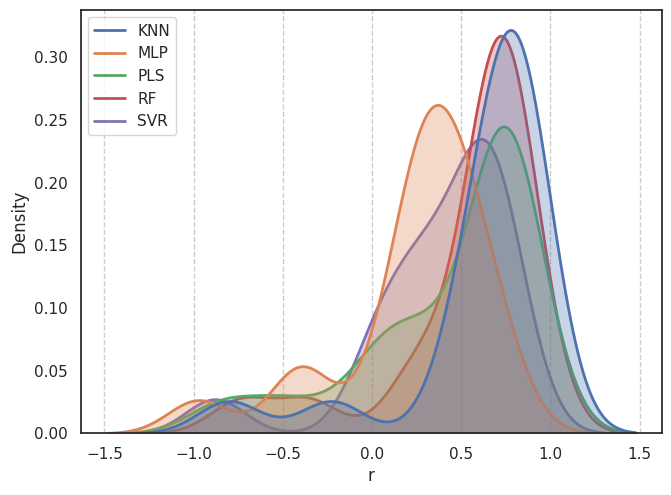

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.5))

MODEL_COLORS  = sns.color_palette("deep", len(MODELS))

ax = sns.kdeplot(
    df_grouped.reset_index(), x='r',
    hue='model', palette=MODEL_COLORS,
    fill=True, alpha=0.3, linewidth=2,
    legend=False, ax=ax
)

ax.grid(True, axis='x', ls='--')

legend_elements = [
    Line2D([0], [0], color=color, lw=2, label=model)
    for color, model in zip(MODEL_COLORS, MODELS)
]

ax.legend(handles=legend_elements, loc='upper left', facecolor="w")

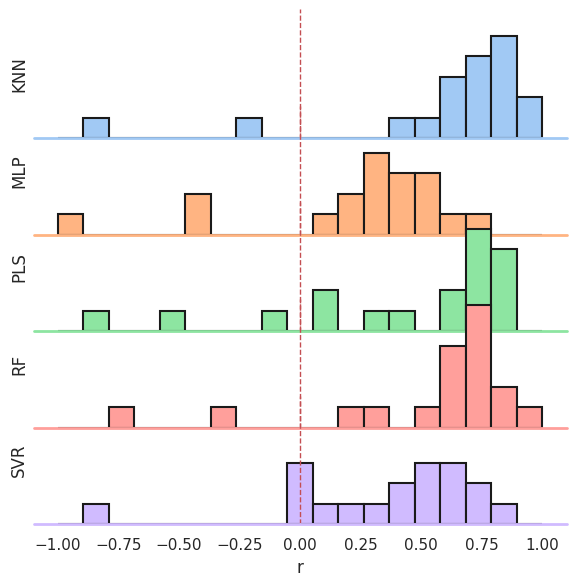

In [ ]:
g = sns.FacetGrid(
    df_grouped.reset_index(), row='model', hue='model', aspect=5, height=1.25, palette=MODEL_COLORS,
    sharey=True, sharex=True
)

g.map(
    sns.histplot, 'r',
    clip_on=False, alpha=1, linewidth=1.5, bins=np.linspace(-1, 1, 20), edgecolor='k'
)

g.map(plt.axvline, x=0, lw=1, ls="--", c="r", clip_on=False)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(MODELS[i])

g.fig.subplots_adjust(hspace=-0.25)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g

/home/degraff/.conda/envs/pcmr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/degraff/.conda/envs/pcmr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


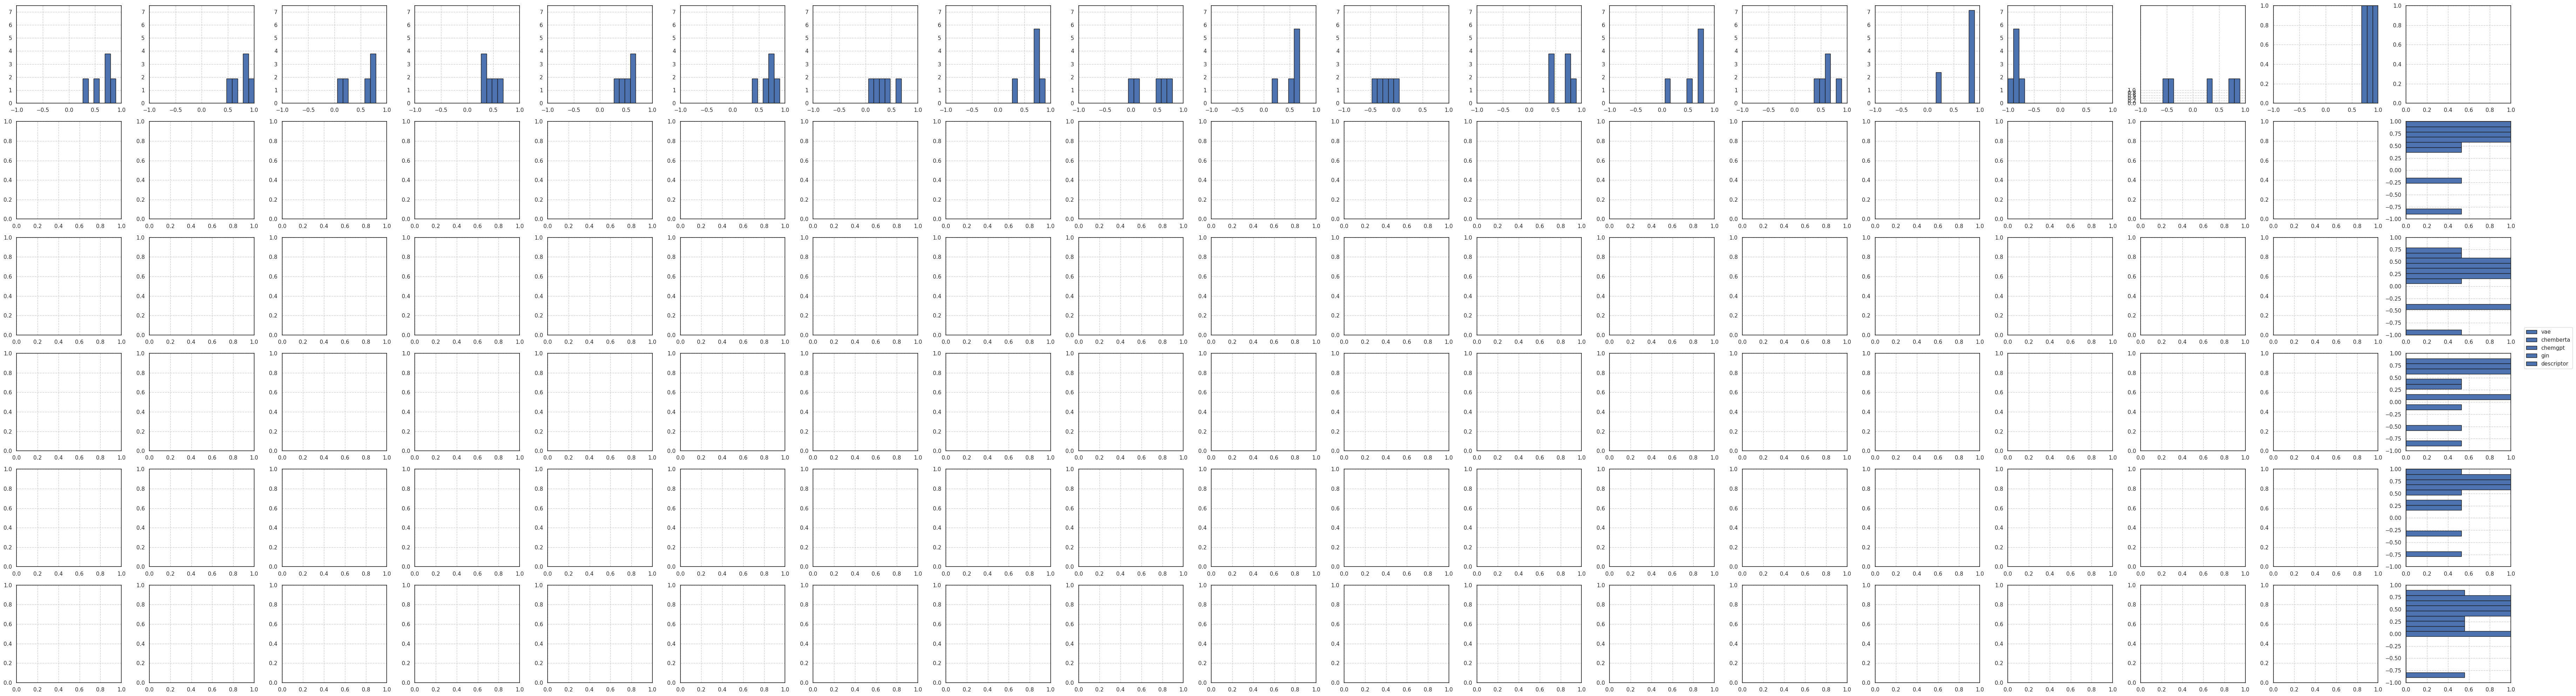

In [ ]:
df = df.sort_values(["model", "dataset", "features"])

MODELS = df["model"].unique()
DATASETS = df["dataset"].unique()
colors = sns.color_palette("deep", 5)
markers = ['o', 'X', 'P', 's', 'D']

nrows = len(MODELS)
ncols = len(DATASETS)
fig, axs = plt.subplots(
    nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=False, sharey=False
)

def corr_plot(ax: plt.Axes, xs, ys, markers, colors, labels):
    BUFFER = 0.03

    for x, y, m, c, l in zip(xs, ys, markers, colors, labels):
        ax.scatter(x, y, 50, marker=m, color=c, edgecolors='k', label=l)

    r, _ = scipy.stats.pearsonr(xs, ys)
    s = rf"$r = {r:0.3f}$"
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='none')
    ax.text(
        0 + BUFFER, 1 - BUFFER, s,
        ha="left", va="top", fontsize=10, transform=ax.transAxes, bbox=bbox
    )
    
    ax.grid(True)


for i, model in enumerate(MODELS):   
    for j, dset in enumerate(DATASETS):

        s = df.query(f"model == '{model}' and dataset == '{dset}'")
        corr_plot(
            axs[i+1, j], s["ROGI"].values, s["RMSE"].values, markers, colors, s.features
        )

        axs[i, j].set_title(f"{model} | {dset}")

fig.legend(s.features, loc='center left', bbox_to_anchor=(1.0, 0.5))
# fig.subplots_adjust(wspace=1)
# fig.supxlabel(r"$N_{\mathrm{clusters}} / N$", fontsize=16)
# fig.supylabel(r"$2(\sigma_0 - \sigma_t)$", x=0.01, fontsize=16)

fig.tight_layout()